In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from healpy.newvisufunc import projview
import itertools as it
import fitsio
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import time
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
import multipoles
import ellisbaldwin
from qso_sample import QSOSample
import dipole
import mock_maps

### load sample

In [3]:
catdir = '/scratch/aew492/quasars/catalogs'
mask_fn = os.path.join(catdir, 'masks/mask_master_hpx_r1.0.fits')

d = QSOSample(initial_catfn=os.path.join(catdir, 'quaia/quaia_G20.5.fits'),
            mask_fn=mask_fn,
            mag='g', maglim=20.,
            blim=30)
selfunc_fn = os.path.join(catdir, f'quaia/selfuncs/selection_function_NSIDE{d.NSIDE}_G20.0_blim15.fits')
expected_dipamp = ellisbaldwin.compute_expected_dipole_gaia(d.table, maglimit=d.maglim,
                                                    min_g=19.5, max_g=20.5)
d.cut_mag()  # cut all sources fainter than the input magnitude limit
d.cut_galactic_plane_hpx()  # cut all sources with |b|<blim from the working source table
selfunc = d.get_selfunc(selfunc=selfunc_fn) # load selection function

# get masked datamap
masked_datamap = d.construct_masked_datamap(selfunc=selfunc, return_map=True)
# mean density in the masked datamap
mu = np.nanmean(masked_datamap)
print(f"\nmean density in masked datamap = {mu:.2f} quasars per healpixel\n" + \
            f"expected dipole amplitude = {expected_dipamp:.6f}", flush=True)

loading initial catalog, /scratch/aew492/quasars/catalogs/quaia/quaia_G20.5.fits
1295502 sources in initial catalog.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.295
	effective alpha = 0.758
	expected dipole amplitude = 0.0053
cut G > 20.0 -> 755850 sources left.
cut |b| <= 30 based on healpix mask -> 530559 sources left.
defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0.5

mean density in masked datamap = 33.60 quasars per healpixel
expected dipole amplitude = 0.005276


In [4]:
# expected C1
expected_C1 = 4 * np.pi / 9 * expected_dipamp**2

#### generate mock healpix maps

In [5]:
# dipole
dipdir = dipole.cmb_dipole()[1]
# dipdir = SkyCoord(0, 0, unit='deg', frame='icrs') # !!
input_dipole_comps = tools.dipole_dir_to_comps(dipdir)  # norm = 1.
input_dipole_comps *= expected_dipamp
print("input dipole components = ", input_dipole_comps, flush=True)

dipole_map = mock_maps.generate_mock_dipole_map(input_dipole_comps, noise=False)
dipole_map_with_noise = mock_maps.generate_mock_dipole_map(input_dipole_comps, noise=True, mu=mu)
masked_dipole_map_with_noise = dipole_map_with_noise.copy()
masked_dipole_map_with_noise[~d.mask] = np.nan

input dipole components =  [-0.00511622  0.00110742 -0.00065623]


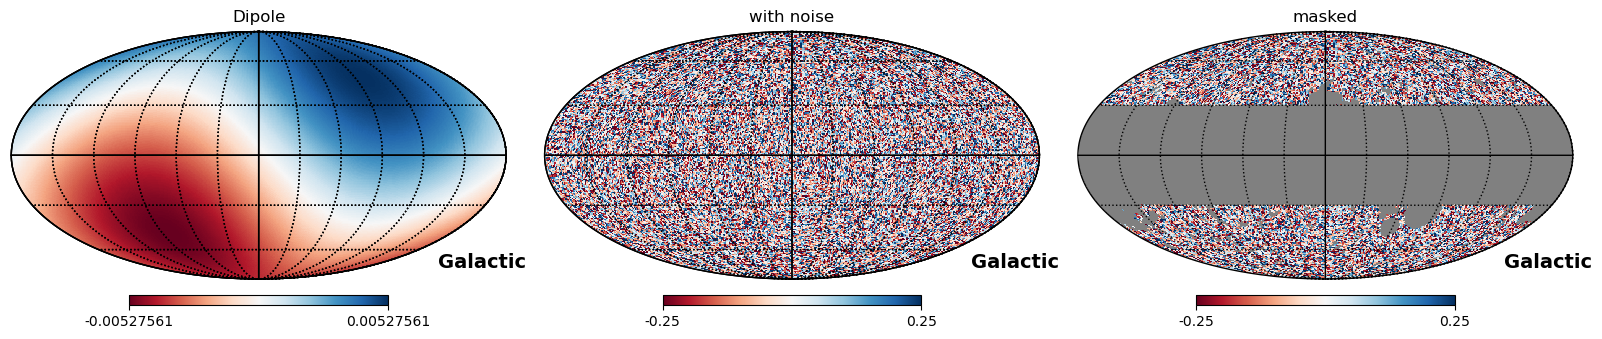

In [6]:
fig = plt.figure(figsize=(16,3))
kwargs = dict(fig=fig, cmap='RdBu', coord=['C','G'])
hp.mollview(dipole_map, sub=(1,3,1), title='Dipole',  **kwargs)
hp.graticule()
hp.mollview(dipole_map_with_noise, sub=(1,3,2), title='with noise', min=-.25, max=.25, **kwargs)
hp.graticule()
hp.mollview(masked_dipole_map_with_noise, sub=(1,3,3), title='masked', min=-.25, max=.25, **kwargs)
hp.graticule()

In [7]:
hp.fit_dipole(dipole_map), hp.fit_dipole(dipole_map_with_noise), hp.fit_dipole(masked_dipole_map_with_noise)

((3.713319083043492e-20, array([-0.00511622,  0.00110742, -0.00065623])),
 (-7.014985243243132e-17, array([-0.00536767, -0.00159858, -0.00053298])),
 (0.0013074666299260655, array([-0.00464918, -0.00519511,  0.00099188])))

#### comparing dipole functions...

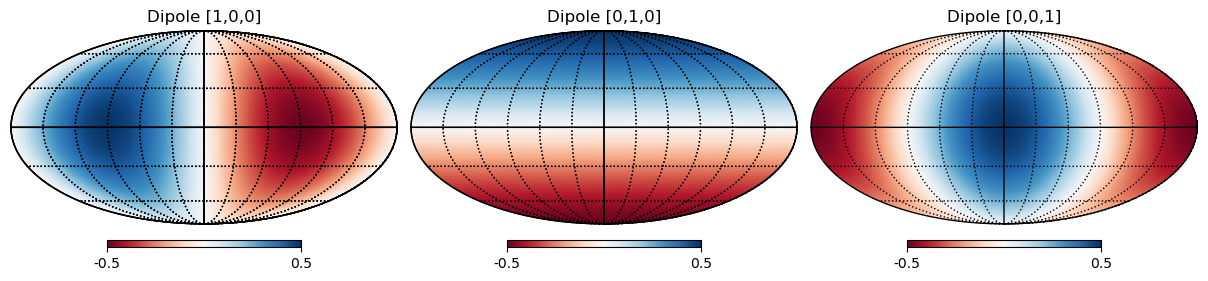

In [8]:
fig = plt.figure(figsize=(12,3))
kwargs = dict(fig=fig, cmap='RdBu', min=-0.5, max=0.5)
hp.mollview(multipoles.multipole_map([1,0,0]), sub=(1,3,1), title='Dipole [1,0,0]', **kwargs)
hp.graticule()
hp.mollview(multipoles.multipole_map([0,1,0]), sub=(1,3,2), title='Dipole [0,1,0]', **kwargs)
hp.graticule()
hp.mollview(multipoles.multipole_map([0,0,1]), sub=(1,3,3), title='Dipole [0,0,1]', **kwargs)
hp.graticule()

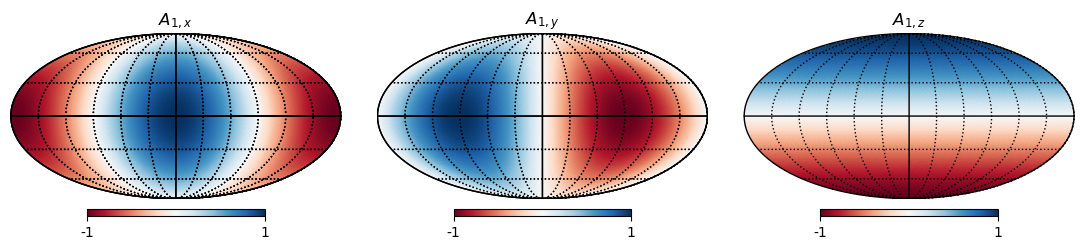

In [9]:
fig = plt.figure(figsize=(11,2))
kwargs = dict(fig=fig, cmap='RdBu', min=-1, max=1)
hp.mollview(dipole.dipole_map([0,1,0,0]), sub=(1,3,1), title=r'$A_{1,x}$', **kwargs)
hp.graticule()
hp.mollview(dipole.dipole_map([0,0,1,0]), sub=(1,3,2), title=r'$A_{1,y}$', **kwargs)
hp.graticule()
hp.mollview(dipole.dipole_map([0,0,0,1]), sub=(1,3,3), title=r'$A_{1,z}$', **kwargs)
hp.graticule()

In [11]:
# real forms of the spherical harmonics (is this the same as multipole_map()?)
theta, phi = hp.pix2ang(d.NSIDE, ipix=np.arange(d.NPIX))
Y1neg1 = multipoles.real_sph_harm(-1, 1, theta, phi)
Y10 = multipoles.real_sph_harm(0, 1, theta, phi)
Y11 = multipoles.real_sph_harm(1, 1, theta, phi)

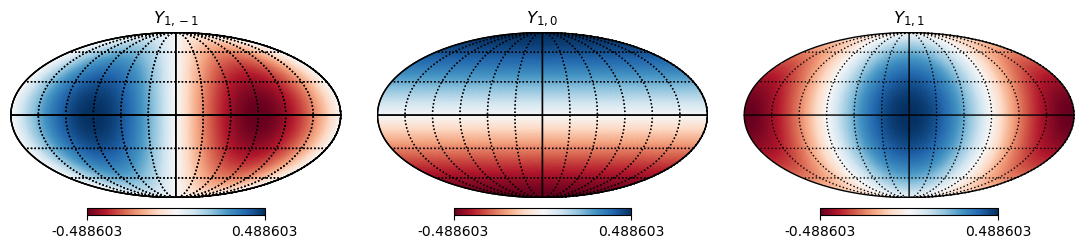

In [14]:
fig = plt.figure(figsize=(11,2))
kwargs = dict(fig=fig, cmap='RdBu', min=-np.sqrt(3/(4*np.pi)), max=np.sqrt(3/(4*np.pi)))
hp.mollview(Y1neg1, sub=(1,3,1), title=r'$Y_{1,-1}$', **kwargs)
hp.graticule()
hp.mollview(Y10, sub=(1,3,2), title=r'$Y_{1,0}$', **kwargs)
hp.graticule()
hp.mollview(Y11, sub=(1,3,3), title=r'$Y_{1,1}$', **kwargs)
hp.graticule()

In [15]:
max(Y1neg1), max(Y10), max(Y11)

(0.48857600280098784, 0.488562749328709, 0.48857600280098784)

### measure spherical harmonic coefficients

In [10]:
# inputs
max_ell = 6
ntrials = 10
regularize = True

In [11]:
if regularize:
    Lambda_dict = np.load(f'/scratch/aew492/quasars/regularization/Lambdas_quaia_noise-matched.npy',
                            allow_pickle=True).item()
    Lambda = Lambda_dict[max_ell]
else:
    Lambda = 0.
print(f"Lambda = {Lambda:.3e}", flush=True)

Lambda = 7.372e-03


In [12]:
# Cells from the pure dipole, NO regularization
ells, Cells_puredipole_noreg, alms_puredipole_noreg = multipoles.compute_Cells_in_overdensity_map_Lambda(dipole_map, Lambda=0,
                                                                max_ell=max_ell, return_alms=True)
# Cells from the pure dipole WITH regularization
ells, Cells_puredipole, alms_puredipole = multipoles.compute_Cells_in_overdensity_map_Lambda(dipole_map, Lambda=Lambda,
                                                                max_ell=max_ell, return_alms=True)

In [23]:
masked_dipole_map = dipole_map.copy()
masked_dipole_map[~d.mask] = np.nan
# Cells from the masked dipole, NO regularization
ells, Cells_maskeddipole_noreg, alms_maskeddipole_noreg = multipoles.compute_Cells_in_overdensity_map_Lambda(masked_dipole_map, Lambda=0,
                                                                max_ell=max_ell, return_alms=True)
# Cells from the masked dipole WITH regularization
ells, Cells_maskeddipole, alms_maskeddipole = multipoles.compute_Cells_in_overdensity_map_Lambda(masked_dipole_map, Lambda=Lambda,
                                                                max_ell=max_ell, return_alms=True)

Text(0.5, 1.0, 'Angular power spectra, Quaia G<20.0 mock dipole map')

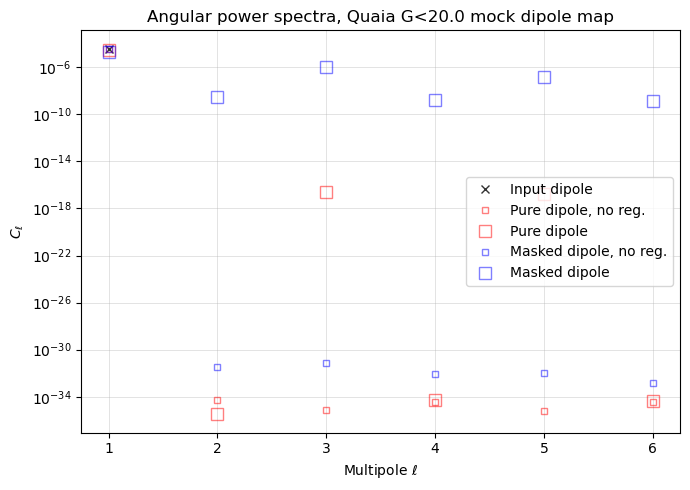

In [24]:
# plot
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(marker='s', ls='None', c='None')
ax.plot(1, expected_C1, c='k', marker='x', alpha=0.8, label='Input dipole', ls='None')
ax.plot(ells[1:], Cells_puredipole_noreg[1:], mec='r', ms=4, alpha=0.5, label='Pure dipole, no reg.', **kwargs)
ax.plot(ells[1:], Cells_puredipole[1:], mec='r', ms=8, alpha=0.5, label='Pure dipole', **kwargs)
ax.plot(ells[1:], Cells_maskeddipole_noreg[1:], mec='b', ms=4, alpha=0.5, label='Masked dipole, no reg.', **kwargs)
ax.plot(ells[1:], Cells_maskeddipole[1:], mec='b', ms=8, alpha=0.5, label='Masked dipole', **kwargs)
ax.grid(alpha=0.5, lw=0.5)
ax.semilogy()
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.legend()
ax.set_title('Angular power spectra, Quaia G<20.0 mock dipole map')

In [15]:
# reconstruct the best-fit maps from the alms
reconstructed_map_noreg = multipoles.reconstruct_map(alms_maskeddipole_noreg)
reconstructed_map = multipoles.reconstruct_map(alms_maskeddipole)

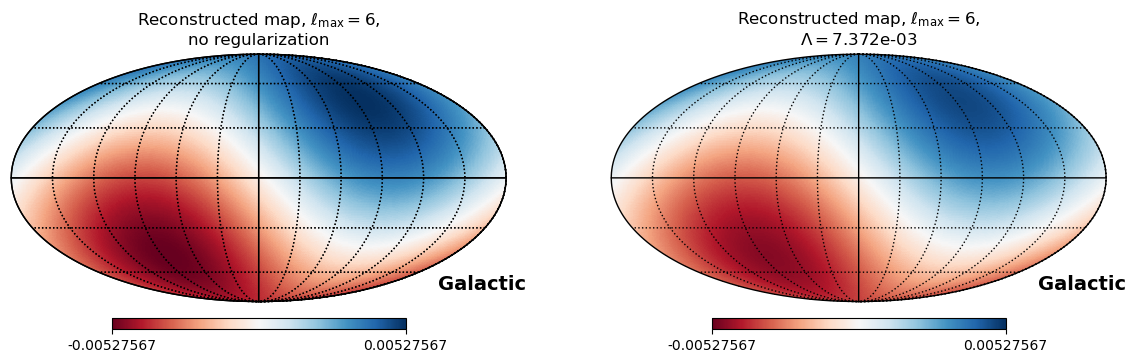

In [16]:
fig = plt.figure(figsize=(12,3))
kwargs = dict(fig=fig, cmap='RdBu', coord=['C','G'], min=-expected_dipamp, max=expected_dipamp)
hp.mollview(reconstructed_map_noreg, sub=(1,2,1),
            title=r'Reconstructed map, $\ell_\mathrm{max}=$'f'{max_ell},\nno regularization',  **kwargs)
hp.graticule()
hp.mollview(reconstructed_map, sub=(1,2,2),
            title=r'Reconstructed map, $\ell_\mathrm{max}=$'f'{max_ell},\n'r'$\Lambda=$'f'{Lambda:.3e}', **kwargs)
hp.graticule()

In [21]:
max(reconstructed_map_noreg), max(reconstructed_map), expected_dipamp

(0.005275613806901491, 0.004828303380364675, <Quantity 0.00527567>)

In [17]:
# with noise: average of multiple trials
Cells_noreg_trials = np.empty((ntrials, max_ell))
Cells_trials = np.empty((ntrials, max_ell))
maps = []
for itrial in range(ntrials):
    print(f"trial {itrial}", flush=True)
    # generate mock healpix density map
    mock_overdensity_map = mock_maps.generate_mock_dipole_map(input_dipole_comps, noise=True, mu=mu)    
    # mask
    mock_overdensity_map[~d.mask] = np.nan
    maps.append(mock_overdensity_map)
    print(f"\tmean overdensity = {np.nanmean(mock_overdensity_map):.3e}", flush=True)

    ells, Cells_noreg, alms = multipoles.compute_Cells_in_overdensity_map_Lambda(mock_overdensity_map, Lambda=0,
                                                                max_ell=max_ell, return_alms=True)
    ells, Cells, alms = multipoles.compute_Cells_in_overdensity_map_Lambda(mock_overdensity_map, Lambda=Lambda,
                                                                max_ell=max_ell, return_alms=True)
    # add this trial
    Cells_noreg_trials[itrial] = Cells_noreg[1:]
    Cells_trials[itrial] = Cells[1:]
    print(f"\tbest-fit dipole components = ", alms[1:4], f"\n\tCells = ", Cells[1:],
            flush=True)

Cells_noreg = np.nanmean(Cells_noreg_trials, axis=0)
Cells = np.nanmean(Cells_trials, axis=0)
print("Cells = ", Cells, flush=True)

trial 0
	mean overdensity = 1.171e-03
	best-fit dipole components =  [-0.00459805 -0.00154182 -0.00703202] 
	Cells =  [2.43228664e-05 1.33550742e-06 5.04300145e-06 1.24251387e-05
 9.41627781e-06 8.93613683e-06]
trial 1
	mean overdensity = 9.973e-04
	best-fit dipole components =  [-0.00480468  0.00382655 -0.00820868] 
	Cells =  [3.50365920e-05 4.29345371e-06 9.17596207e-06 4.08139133e-06
 5.85581184e-06 1.43638764e-05]
trial 2
	mean overdensity = 1.637e-03
	best-fit dipole components =  [-0.000323    0.00456134 -0.00940656] 
	Cells =  [3.64645124e-05 1.49508537e-05 5.99615960e-06 9.60009506e-06
 1.14486733e-05 8.85027480e-06]
trial 3
	mean overdensity = -5.142e-04
	best-fit dipole components =  [ 0.00223553  0.00365502 -0.00981768] 
	Cells =  [3.82478605e-05 4.02514861e-06 1.63389524e-05 4.32924921e-06
 1.55856145e-05 2.33357487e-05]
trial 4
	mean overdensity = 2.351e-03
	best-fit dipole components =  [-0.0013114  -0.00261484 -0.00740277] 
	Cells =  [2.11194014e-05 1.33480032e-05 9.7684

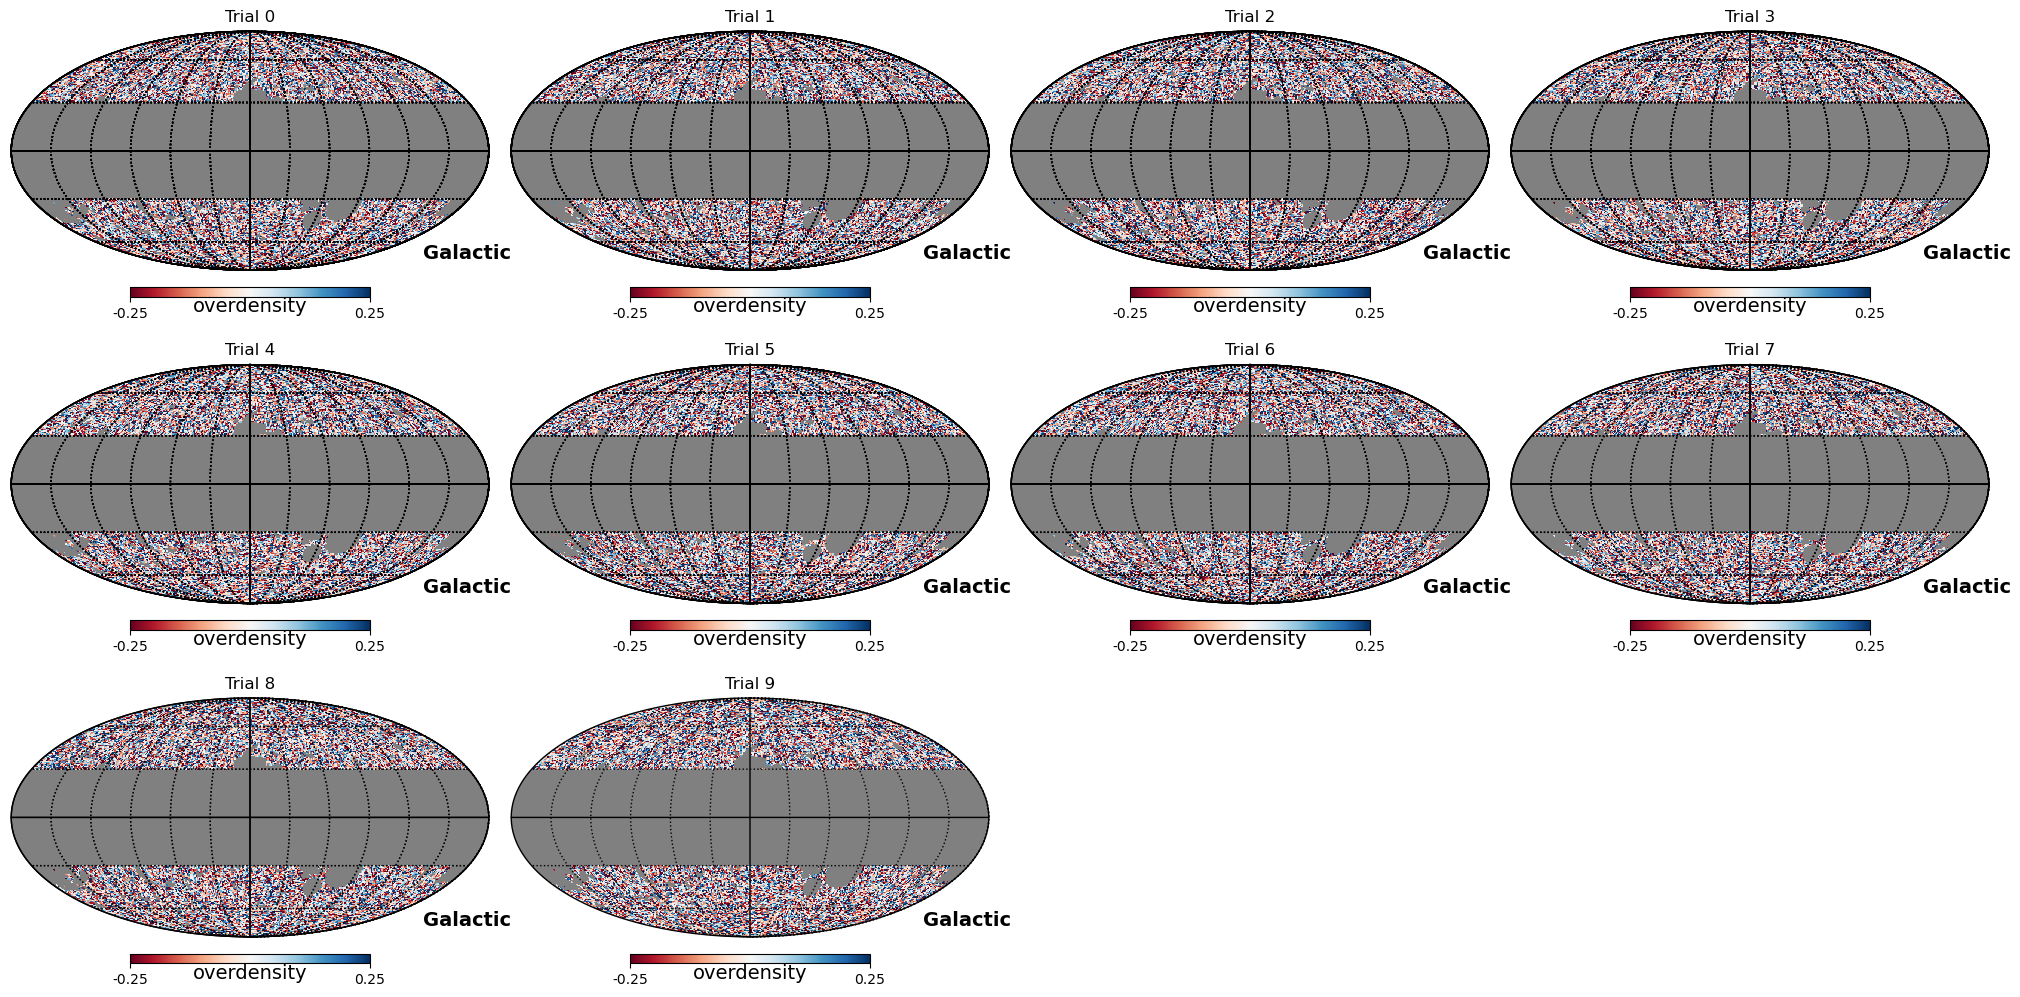

In [18]:
fig = plt.figure(figsize=(20,10))
for itrial in range(ntrials):
    hp.mollview(maps[itrial], coord=['C','G'], title=f'Trial {itrial}', min=-.25, max=.25, unit='overdensity',
                fig=fig, sub=(3,4,itrial+1), cmap='RdBu')
    hp.graticule()

Text(0.5, 1.0, 'Angular power spectra, Quaia G<20.0 mock dipole map')

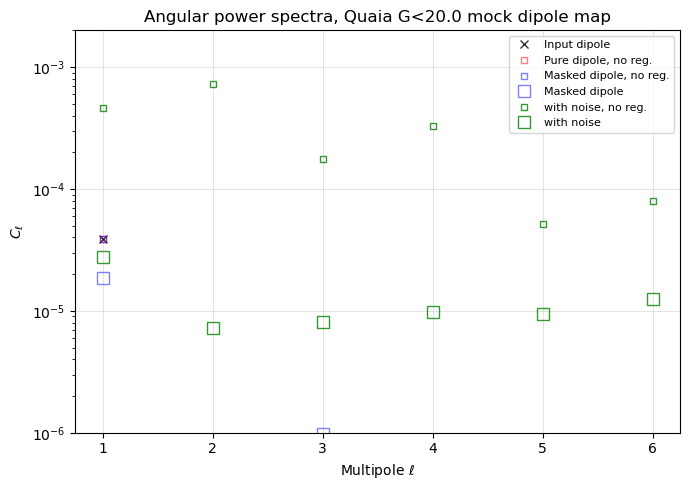

In [26]:
# plot
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(marker='s', ls='None', c='None')
ax.plot(1, expected_C1, c='k', marker='x', alpha=0.8, label='Input dipole', ls='None')
ax.plot(ells[1:], Cells_puredipole_noreg[1:], mec='r', ms=4, alpha=0.5, label='Pure dipole, no reg.', **kwargs)
# ax.plot(ells[1:], Cells_puredipole[1:], mec='r', ms=8, alpha=0.5, label='Pure dipole', **kwargs)
ax.plot(ells[1:], Cells_maskeddipole_noreg[1:], mec='b', ms=4, alpha=0.5, label='Masked dipole, no reg.', **kwargs)
ax.plot(ells[1:], Cells_maskeddipole[1:], mec='b', ms=8, alpha=0.5, label='Masked dipole', **kwargs)
ax.plot(ells[1:], Cells_noreg, mec='g', ms=4, alpha=0.8, label='with noise, no reg.', **kwargs)
ax.plot(ells[1:], Cells, mec='g', ms=8, alpha=0.8, label='with noise', **kwargs)
ax.grid(alpha=0.5, lw=0.5)
ax.semilogy()
ax.set_ylim(1e-6,2e-3)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.legend(fontsize=8, loc=1)
ax.set_title('Angular power spectra, Quaia G<20.0 mock dipole map')